In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:2]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dacon-dataset/sample_submission.csv
/kaggle/input/dacon-dataset/test.csv
/kaggle/input/dacon-dataset/test/641.png
/kaggle/input/dacon-dataset/test/173.png
/kaggle/input/dacon-dataset/train/가구수정/11.png
/kaggle/input/dacon-dataset/train/가구수정/4.png
/kaggle/input/dacon-dataset/train/터짐/94.png
/kaggle/input/dacon-dataset/train/터짐/48.png
/kaggle/input/dacon-dataset/train/들뜸/48.png
/kaggle/input/dacon-dataset/train/들뜸/37.png
/kaggle/input/dacon-dataset/train/피스/48.png
/kaggle/input/dacon-dataset/train/피스/37.png
/kaggle/input/dacon-dataset/train/창틀,문틀수정/11.png
/kaggle/input/dacon-dataset/train/창틀,문틀수정/4.png
/kaggle/input/dacon-dataset/train/녹오염/11.png
/kaggle/input/dacon-dataset/train/녹오염/4.png
/kaggle/input/dacon-dataset/train/석고수정/48.png
/kaggle/input/dacon-dataset/train/석고수정/37.png
/kaggle/input/dacon-dataset/train/훼손/1231.png
/kaggle/input/dacon-dataset/train/훼손/1017.png
/kaggle/input/dacon-dataset/train/꼬임/173.png
/kaggle/input/dacon-dataset/train/꼬임/94.png
/kaggle/input/dac

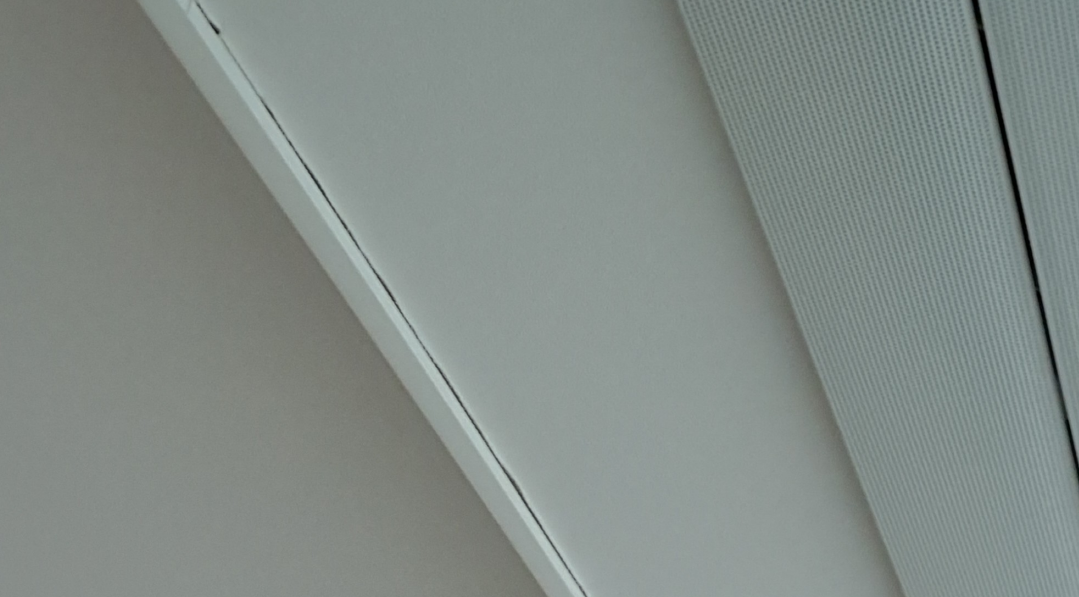

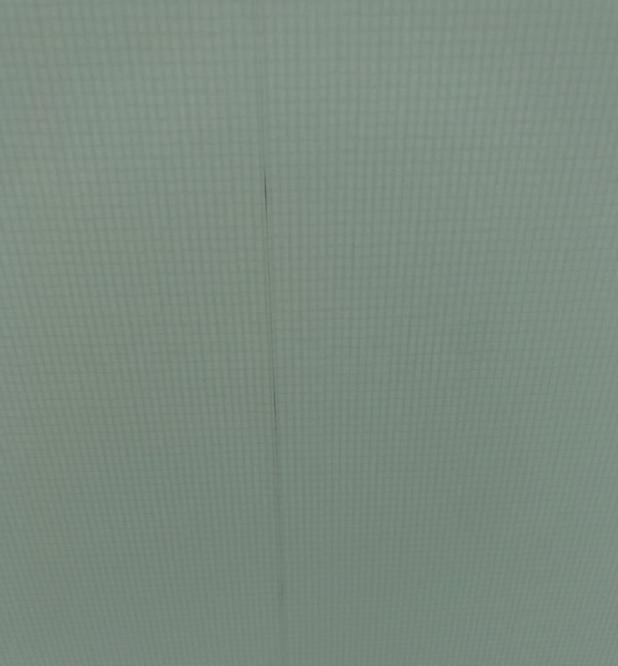

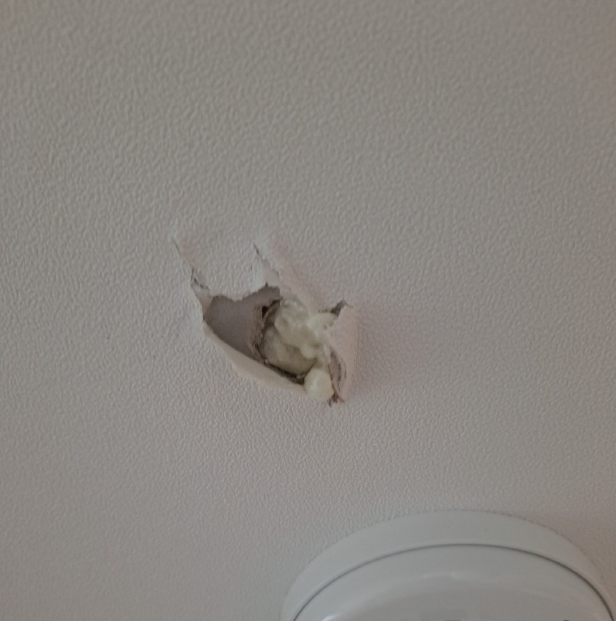

In [78]:
from PIL import Image
display(
Image.open('/kaggle/input/dacon-dataset/train/몰딩수정/48.png'),
Image.open('/kaggle/input/dacon-dataset/train/이음부불량/11.png'),
Image.open('/kaggle/input/dacon-dataset/train/오타공/48.png')
)

In [19]:
cnt = 0
label = []
path = []
for dirname, _, filenames in os.walk('/kaggle/input/dacon-dataset/train/'):
    for filename in filenames[:]:
        label.append(dirname.split('/')[-1])
        path.append(os.path.join(dirname, filename))
        cnt += 1
print(cnt)
print(len(label),label[:5])
print(len(path),path[:5])


3457
3457 ['가구수정', '가구수정', '가구수정', '가구수정', '가구수정']
3457 ['/kaggle/input/dacon-dataset/train/가구수정/11.png', '/kaggle/input/dacon-dataset/train/가구수정/4.png', '/kaggle/input/dacon-dataset/train/가구수정/9.png', '/kaggle/input/dacon-dataset/train/가구수정/1.png', '/kaggle/input/dacon-dataset/train/가구수정/2.png']


In [22]:
train = pd.DataFrame(
    {'label' : label,'path' : path}
    )
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3457 entries, 0 to 3456
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3457 non-null   object
 1   path    3457 non-null   object
dtypes: object(2)
memory usage: 54.1+ KB


In [24]:
train.label.value_counts()

훼손         1405
오염          595
걸레받이수정      307
꼬임          210
터짐          162
곰팡이         145
오타공         142
몰딩수정        130
면불량          99
석고수정         57
들뜸           54
피스           51
창틀,문틀수정      27
울음           22
이음부불량        17
녹오염          14
가구수정         12
틈새과다          5
반점            3
Name: label, dtype: int64

In [27]:
from sklearn.model_selection import train_test_split
X_train,X_val = train_test_split(train,test_size=0.2, random_state=2023, stratify=train['label'])
display(X_train.label.value_counts(),X_val.label.value_counts())

훼손         1124
오염          476
걸레받이수정      245
꼬임          168
터짐          129
곰팡이         116
오타공         113
몰딩수정        104
면불량          79
석고수정         46
들뜸           43
피스           41
창틀,문틀수정      22
울음           18
이음부불량        14
녹오염          11
가구수정         10
틈새과다          4
반점            2
Name: label, dtype: int64

훼손         281
오염         119
걸레받이수정      62
꼬임          42
터짐          33
곰팡이         29
오타공         29
몰딩수정        26
면불량         20
들뜸          11
석고수정        11
피스          10
창틀,문틀수정      5
울음           4
녹오염          3
이음부불량        3
가구수정         2
반점           1
틈새과다         1
Name: label, dtype: int64

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator()
train_generator = idg.flow_from_dataframe(X_train, y_col='label', x_col='path')
valid_generator = idg.flow_from_dataframe(X_val, y_col='label', x_col='path')

Found 2765 validated image filenames belonging to 19 classes.
Found 692 validated image filenames belonging to 19 classes.


In [79]:
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.callbacks import *
es = EarlyStopping(patience=3, restore_best_weights=True)
rl = ReduceLROnPlateau(patience=2, verbose=1)

In [89]:
model = Sequential()
model.add(EfficientNetB4(include_top=False, pooling='avg'))
model.add(Dense(19, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

In [90]:
model.fit(train_generator,validation_data=valid_generator, epochs=9, callbacks=[es,rl])

Epoch 1/9


2023-04-16 17:21:51.776496: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


87/87 [==============================] - 136s 774ms/step - loss: 1.2582 - acc: 0.6344 - val_loss: 1.1860 - val_acc: 0.7095 - lr: 0.0010
Epoch 2/9
87/87 [==============================] - 64s 737ms/step - loss: 0.5657 - acc: 0.8203 - val_loss: 0.9930 - val_acc: 0.7225 - lr: 0.0010
Epoch 3/9
87/87 [==============================] - 64s 734ms/step - loss: 0.4130 - acc: 0.8694 - val_loss: 1.1832 - val_acc: 0.7630 - lr: 0.0010
Epoch 4/9
87/87 [==============================] - ETA: 0s - loss: 0.2907 - acc: 0.9092
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
87/87 [==============================] - 64s 737ms/step - loss: 0.2907 - acc: 0.9092 - val_loss: 1.3349 - val_acc: 0.7023 - lr: 0.0010
Epoch 5/9
87/87 [==============================] - 65s 743ms/step - loss: 0.1360 - acc: 0.9577 - val_loss: 0.8082 - val_acc: 0.8049 - lr: 1.0000e-04
Epoch 6/9
87/87 [==============================] - 65s 738ms/step - loss: 0.0568 - acc: 0.9837 - val_loss: 0.7762 - val_acc: 

In [91]:
test = pd.read_csv('/kaggle/input/dacon-dataset/test.csv')
test['img_path'] = test['img_path'].apply(lambda x : x[1:])
test['img_path'] = '/kaggle/input/dacon-dataset' + test['img_path']
test

,id,img_path
0,TEST_000,/kaggle/input/dacon-dataset/test/000.png
1,TEST_001,/kaggle/input/dacon-dataset/test/001.png
2,TEST_002,/kaggle/input/dacon-dataset/test/002.png
3,TEST_003,/kaggle/input/dacon-dataset/test/003.png
4,TEST_004,/kaggle/input/dacon-dataset/test/004.png
...,...,...
787,TEST_787,/kaggle/input/dacon-dataset/test/787.png
788,TEST_788,/kaggle/input/dacon-dataset/test/788.png
789,TEST_789,/kaggle/input/dacon-dataset/test/789.png
790,TEST_790,/kaggle/input/dacon-dataset/test/790.png


In [92]:
test_generator = idg.flow_from_dataframe(test, x_col='img_path', class_mode=None, shuffle=False)

Found 792 validated image filenames.


In [93]:
result = model.predict(test_generator)
result

25/25 [==============================] - 14s 438ms/step


array([[5.7412239e-05, 7.6864503e-04, 3.3669127e-04, ..., 1.3873128e-04,
        9.5999982e-05, 9.4601196e-01],
       [1.0579371e-05, 1.6964275e-04, 1.1466589e-04, ..., 2.2783190e-06,
        1.3732345e-05, 4.6193507e-03],
       [1.1991838e-07, 3.5109720e-06, 5.8887113e-04, ..., 5.7783773e-06,
        3.3376713e-05, 9.9103898e-01],
       ...,
       [1.3845573e-04, 3.2781816e-05, 1.7000910e-02, ..., 2.9085208e-05,
        3.3161814e-05, 6.7172252e-04],
       [1.5907668e-05, 1.5225155e-04, 8.2609442e-04, ..., 9.3067765e-06,
        1.9846363e-04, 2.9787299e-01],
       [3.4310985e-01, 8.3898206e-04, 2.0916203e-04, ..., 1.1019223e-02,
        7.7664823e-04, 2.0500626e-02]], dtype=float32)

In [94]:
class_name = X_train.label.tolist()
class_num = train_generator.classes

In [95]:
dic = {key:val for key,val in zip(class_num,class_name)}
result = np.argmax(result,axis=1)
result = np.vectorize(dic.get)(result)
result

array(['훼손', '오염', '훼손', '몰딩수정', '오염', '훼손', '오염', '훼손', '오염', '오타공',
       '몰딩수정', '오타공', '오염', '오염', '훼손', '면불량', '훼손', '터짐', '훼손', '오염',
       '창틀,문틀수정', '훼손', '오염', '터짐', '가구수정', '훼손', '면불량', '곰팡이', '곰팡이',
       '훼손', '오염', '훼손', '훼손', '오염', '오염', '훼손', '훼손', '훼손', '오타공', '훼손',
       '오염', '오염', '터짐', '면불량', '오염', '훼손', '훼손', '훼손', '훼손', '오염', '오염',
       '오염', '오염', '터짐', '훼손', '훼손', '훼손', '곰팡이', '오염', '오염', '오타공',
       '몰딩수정', '훼손', '오염', '훼손', '오염', '오염', '오염', '훼손', '터짐', '오염', '오염',
       '오염', '녹오염', '훼손', '터짐', '훼손', '오염', '훼손', '오염', '면불량', '훼손', '훼손',
       '훼손', '걸레받이수정', '훼손', '훼손', '터짐', '오염', '오염', '오염', '훼손', '훼손',
       '오염', '훼손', '훼손', '훼손', '터짐', '오타공', '오염', '훼손', '훼손', '훼손', '터짐',
       '훼손', '훼손', '가구수정', '몰딩수정', '훼손', '훼손', '터짐', '훼손', '훼손', '훼손',
       '오염', '훼손', '훼손', '훼손', '오염', '훼손', '훼손', '훼손', '훼손', '터짐', '훼손',
       '훼손', '훼손', '훼손', '훼손', '오염', '훼손', '오염', '꼬임', '오염', '훼손', '오염',
       '터짐', '훼손', '훼손', '오염', '터짐', '훼손', '오염', '오염', '훼손'

In [96]:
sub = pd.read_csv('/kaggle/input/dacon-dataset/sample_submission.csv')
sub['label'] = result
sub


,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,훼손
3,TEST_003,몰딩수정
4,TEST_004,오염
...,...,...
787,TEST_787,훼손
788,TEST_788,오염
789,TEST_789,오염
790,TEST_790,오염


In [97]:
sub.to_csv('sub.csv', index=False)